# AMICI Python example "steadystate"
Example using [model_steadystate_scaled.sbml] model to demonstrate and test SBML import and Amici Python interface.

In [1]:
sbml_file = 'model_steadystate_scaled.sbml'
model_name = 'model_steadystate_scaled'
model_output_dir= 'model_steadystate_scaled'

### The example model

In [2]:
import libsbml
SBMLreader = libsbml.SBMLReader()
sbml_doc = SBMLreader.readSBML(sbml_file)
sbml_model = sbml_doc.getModel()

print('Species: ', [s.getId() for s in sbml_model.getListOfSpecies()])

print('\nReactions:')
for reaction in sbml_model.getListOfReactions():
    reactants = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfReactants()])
    products  = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfProducts()])
    reversible = '<' if reaction.getReversible() else ''
    print('%3s: %10s %1s->%10s\t\t[%s]' % (reaction.getId(), 
                        reactants,
                        reversible,
                        products,
                        libsbml.formulaToL3String(reaction.getKineticLaw().getMath())))


Species:  ['x1', 'x2', 'x3']

Reactions:
 r1:       2 x1  ->        x2		[p1 * x1^2]
 r2:   x1 +  x2  ->        x3		[p2 * x1 * x2]
 r3:         x2  ->      2 x1		[p3 * x2]
 r4:         x3  ->  x1 +  x2		[p4 * x3]
 r5:         x3  ->          		[k4 * x3]
 r6:             ->        x1		[p5]


## Importing an SBML model, compiling and generating an AMICI module

In [3]:
import amici

import os
import sys
import numpy as np
import matplotlib.pyplot as plt

def createModule(sbml_file, model_name, model_output_dir):
    """Create Python module from SBML model"""
    sbmlImporter = amici.SbmlImporter(sbml_file)
    sbml = sbmlImporter.sbml
    
    observables = amici.assignmentRules2observables(sbml, filter=lambda variableId: 
                                                    variableId.startswith('observable_') and not variableId.endswith('_sigma'))
    
    print(observables)
    
    sbmlImporter.sbml2amici(model_name, model_output_dir, verbose=True,
                            observables=observables,
                            constantParameters=['k4'],
                            sigmas={'observable_x1withsigma': 'observable_x1withsigma_sigma'})

createModule(sbml_file, model_name, model_output_dir)


{'observable_x1': 'x1', 'observable_x2': 'x2', 'observable_x3': 'x3', 'observable_x1_scaled': 'scaling_x1 * x1', 'observable_x2_offsetted': 'offset_x2 + x2', 'observable_x1withsigma': 'x1'}
running build_ext
building 'model_steadystate_scaled/_model_steadystate_scaled' extension
swigging swig/model_steadystate_scaled.i to swig/model_steadystate_scaled_wrap.cpp
swig -python -c++ -modern -outdir model_steadystate_scaled -I/home/dweindl/.local/lib/python3.6/site-packages/amici/swig -I/home/dweindl/.local/lib/python3.6/site-packages/amici/include -o swig/model_steadystate_scaled_wrap.cpp swig/model_steadystate_scaled.i
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.6-sXpGnM/python3.6-3.6.3=. -specs=/usr/share/dpkg/no-pie-compile.specs -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/home/dweindl/src/AMICI-devel/python/examples/example_steadystate/model_steadystate_scaled -I/home/dweindl/.loc

To use python-generated model in matlab, run:
```
modelName = '';
modelDir = '';
amimodel.compileAndLinkModel(modelName, modelDir, [], [], [], []);
amimodel.generateMatlabWrapper(3, 6, 8, 1, 0, 0, [], [ modelDir '/simulate_test.m'], modelName, 'lin', 1, 1);
```

## Running simulations and analyzing results

In [4]:
sys.path.insert(0, os.path.abspath(model_output_dir))
import model_steadystate_scaled as modelModule

model = modelModule.getModel()

# show default parameters
print('Parameters:', np.array(model.getParameters()))

# simulation using default parameters
model.setTimepoints(amici.DoubleVector(np.linspace(0, 60, 60))) 
solver = model.getSolver()
rdata = amici.runAmiciSimulation(model, solver)

print()
#np.set_printoptions(threshold=8, edgeitems=2)
for key, value in rdata.items():
    print('%12s: ' % key, value)



Parameters: [1.  0.5 0.4 2.  0.1 1.  1.  1. ]

           t:  [ 0.          1.01694915  2.03389831  3.05084746  4.06779661  5.08474576
  6.10169492  7.11864407  8.13559322  9.15254237 10.16949153 11.18644068
 12.20338983 13.22033898 14.23728814 15.25423729 16.27118644 17.28813559
 18.30508475 19.3220339  20.33898305 21.3559322  22.37288136 23.38983051
 24.40677966 25.42372881 26.44067797 27.45762712 28.47457627 29.49152542
 30.50847458 31.52542373 32.54237288 33.55932203 34.57627119 35.59322034
 36.61016949 37.62711864 38.6440678  39.66101695 40.6779661  41.69491525
 42.71186441 43.72881356 44.74576271 45.76271186 46.77966102 47.79661017
 48.81355932 49.83050847 50.84745763 51.86440678 52.88135593 53.89830508
 54.91525424 55.93220339 56.94915254 57.96610169 58.98305085 60.        ]
           x:  [[0.1        0.4        0.7       ]
 [0.57995051 0.73365809 0.0951589 ]
 [0.55996496 0.71470091 0.0694127 ]
 [0.5462855  0.68030366 0.06349394]
 [0.53561883 0.64937432 0.05923555]
 [0.52636487

### Plotting tractories

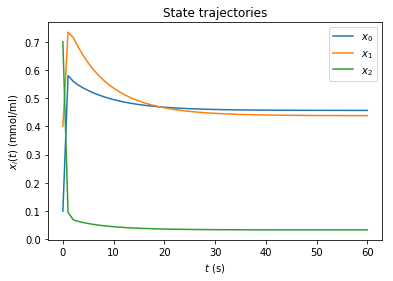

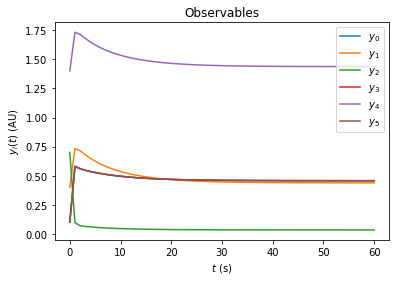

In [5]:
def plotStateTrajectories(rdata):
    for ix in range(rdata['x'].shape[1]):
        plt.plot(rdata['t'], rdata['x'][:, ix], label='$x_%d$' % ix)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$x_i(t)$ (mmol/ml)')
        plt.legend()
        plt.title('State trajectories')
    plt.show()
    
def plotObservableTrajectories(rdata):
    for iy in range(rdata['y'].shape[1]):
        plt.plot(rdata['t'], rdata['y'][:, iy], label='$y_%d$' % iy)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$y_i(t)$ (AU)')
        plt.legend()
        plt.title('Observables')
    
    plt.show()
    sys.path.insert(0, 'test')

plotStateTrajectories(rdata)
plotObservableTrajectories(rdata)

### Computing likelihood

In [6]:
model = modelModule.getModel()
model.setTimepoints(amici.DoubleVector(np.linspace(0, 10, 11))) 
solver = model.getSolver()
rdata = amici.runAmiciSimulation(model, solver)

edata = amici.ExpData(model.get())
edata.my = amici.DoubleVector(rdata['y'].flatten())
edata.sigmay = amici.DoubleVector(np.ones(shape=rdata['y'].shape).flatten())
rdata = amici.runAmiciSimulation(model, solver, edata)

print('Loglikelihood %f' % rdata['llh'])

Loglikelihood -60.649943


## Forward sensitivity analysis

In [7]:
model = modelModule.getModel()
model.setTimepoints(amici.DoubleVector(np.linspace(0, 10, 11))) 
model.requireSensitivitiesForAllParameters()
model.setParameterScale(amici.AMICI_SCALING_NONE)

solver = model.getSolver()
solver.setSensitivityMethod(amici.AMICI_SENSI_FSA)
solver.setSensitivityOrder(amici.AMICI_SENSI_ORDER_FIRST)

rdata = amici.runAmiciSimulation(model, solver)

for key, value in rdata.items():
    if key.startswith('s'):
        print('%12s: ' % key, value)


          sx:  [[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]

 [[-2.00747250e-01  1.19873139e-01 -9.44167985e-03]
  [-1.02561396e-01 -1.88820454e-01  1.01855972e-01]
  [ 4.66193077e-01 -2.86365372e-01  2.39662449e-02]
  [ 4.52560294e-02  1.14631370e-01 -3.34067919e-02]
  [ 4.00672911e-01  1.92564093e-01  4.98877759e-02]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]

 [[-2.23007240e-01  1.53979022e-01 -1.26885280e-02]
  [-1.33426939e-01 -3.15955239e-01  9.49575030e-02]
  [ 5.03470377e-01 -3.52731535e-01  2.8156741

## Adjoint sensitivity analysis

In [8]:
model = modelModule.getModel()
model.setParameterScale(amici.AMICI_SCALING_NONE)
model.setTimepoints(amici.DoubleVector(np.linspace(0, 10, 11))) 
solver = model.getSolver()
solver.setMaxSteps(10**4)

# simulate time-course for artificial data
rdata = amici.runAmiciSimulation(model, solver)
edata = amici.ExpData(model.get())
edata.fixedParameters = model.getFixedParameters()
edata.my = amici.DoubleVector(rdata['y'].flatten())
edata.sigmay = amici.DoubleVector(np.ones(shape=rdata['y'].shape).flatten())

# enable sensitivities
solver.setSensitivityMethod(amici.AMICI_SENSI_ASA)
solver.setSensitivityOrder(amici.AMICI_SENSI_ORDER_FIRST)
model.requireSensitivitiesForAllParameters()

# compute adjoint sensitivities
rdata = amici.runAmiciSimulation(model, solver, edata)
print('Noise-free: llh: %f, sllh: %s' % (rdata['llh'], rdata['sllh']))

# Add some noise
edata.my = amici.DoubleVector(np.multiply(rdata['y'], np.random.normal(0.0, 0.01, rdata['y'].shape)).flatten())
#edata.my = amici.DoubleVector((rdata['y'] * 1.1).flatten())
rdata = amici.runAmiciSimulation(model, solver, edata)
print('Some noise: llh: %f, sllh: %s' % (rdata['llh'], rdata['sllh']))

p = np.array(model.getParameters())

Noise-free: llh: -60.649943, sllh: [0. 0. 0. 0. 0. 0. 0. 0.]
Some noise: llh: -81.392520, sllh: [ -0.60535131  13.9453093    1.45890383  -3.46043573 -36.56923474
  -2.81861858 -17.64991788   0.        ]


## Finite differences gradient check

In [9]:
from scipy.optimize import check_grad
def func(x0, symbol='llh', x0full=None, plist=[], verbose=False):
    p = x0
    if len(plist):
        p = x0full[:]
        p[plist] = x0
    verbose and print('f: p=%s' % p)
       
    solver.setSensitivityOrder(amici.AMICI_SENSI_ORDER_NONE)
    model.setParameters(amici.DoubleVector(p))
    rdata = amici.runAmiciSimulation(model, solver, edata)

    res = np.sum(rdata[symbol])
    return res

def grad(x0, symbol='llh', x0full=None, plist=[], verbose=False):
    p = x0
    if len(plist):
        model.setParameterList(amici.IntVector(plist))
        p = x0full[:]
        p[plist] = x0
    else:
        model.requireSensitivitiesForAllParameters()
    verbose and print('g: p=%s' % p)
    
    solver.setSensitivityMethod(amici.AMICI_SENSI_FSA)
    solver.setSensitivityOrder(amici.AMICI_SENSI_ORDER_FIRST)
    model.setParameters(amici.DoubleVector(p))
    rdata = amici.runAmiciSimulation(model, solver, edata)
    
    res = rdata['s%s' % symbol]
    if not isinstance(res, float):
        if len(res.shape) == 3:
            res = np.sum(res, axis=(0, 2))
    return res

err_norm = check_grad(func, grad, p, 'llh')
print('sllh: |error|_2: %f' % err_norm)
# assert err_norm < 1e-6
print()

for ip in range(model.np()):
    plist = [ip]
    err_norm = check_grad(func, grad, p[plist], 'llh', p, [ip])
    print('sllh: p[%d]: |error|_2: %f' % (ip, err_norm))

print()
for ip in range(model.np()):
    plist = [ip]
    err_norm = check_grad(func, grad, p[plist], 'y', p, [ip])
    print('sy: p[%d]: |error|_2: %f' % (ip, err_norm))

print()
for ip in range(model.np()):
    plist = [ip]
    err_norm = check_grad(func, grad, p[plist], 'x', p, [ip])
    print('sx: p[%d]: |error|_2: %f' % (ip, err_norm))


sllh: |error|_2: 0.000004

sllh: p[0]: |error|_2: 0.000001
sllh: p[1]: |error|_2: 0.000001
sllh: p[2]: |error|_2: 0.000001
sllh: p[3]: |error|_2: 0.000004
sllh: p[4]: |error|_2: 0.000000
sllh: p[5]: |error|_2: 0.000002
sllh: p[6]: |error|_2: 0.000001
sllh: p[7]: |error|_2: 0.000000

sy: p[0]: |error|_2: 0.000001
sy: p[1]: |error|_2: 0.000001
sy: p[2]: |error|_2: 0.000001
sy: p[3]: |error|_2: 0.000001
sy: p[4]: |error|_2: 0.000001
sy: p[5]: |error|_2: 0.000000
sy: p[6]: |error|_2: 0.000000
sy: p[7]: |error|_2: 0.000000

sx: p[0]: |error|_2: 0.000000
sx: p[1]: |error|_2: 0.000001
sx: p[2]: |error|_2: 0.000001
sx: p[3]: |error|_2: 0.000000
sx: p[4]: |error|_2: 0.000001
sx: p[5]: |error|_2: 0.000000
sx: p[6]: |error|_2: 0.000000
sx: p[7]: |error|_2: 0.000000
